In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from synchronous_gossip_protocol import generate_nodes_and_run_stf, NodeGenerator, StateTransitionFunction, Message

sns.set_theme()

# Synchronous Gossip Protocol Design

To approximate the number of cycles needed to spread an update, we can use the discussion in [1, 5]. Consider propagation speed as a function of the number of nodes $N.$ Let $s_0$ denote the proportion of susceptible nodes at the time of introducing the update at one node. Therefore, $s_0 = (N − 1)/N$ . Let $s_t$ denote the proportion of susceptible nodes at the end of the $t^{th}$ cycle. We can calculate the expectation of $s_{t+1}$ as a function of $s_t$. In this case, we have

$$  E(s_{t+1}) = s_t (1 - 1/N)^{N(1 - s_t)} \approx s_t e^{-(1-s_t)} $$

The number of cycles necessary for every node to be updated:

$$ S_N = \log_2 N + \log N + O(1) \text{ as } N \rightarrow \infty $$

where $S_N = min\{t : s_t = 0\}$ is the number of cycles needed to spread the update. Therefore taking around $O(\log N)$ cycles to inform each node about an update

We define two types of messages in a Message Enum (HONEST and ADVERSARIAL). 
The goal is to observe the equilibration behavior of the system

The network has a total number of nodes $n$ of which a fraction of them are sample nodes $s$. 
Sample nodes can be either adversarial $s_{adv}$ (emitting Message.ADVERSARIAL) or honest $s - s_{adv}$ emitting 
(Message.HONEST). We assume a worst case scenario case, with all adversarial sample nodes colluding to send the 
Message.ADVERSARIAL. Non-sample nodes $n-s$, keep an internal storage $C$, and counter of received messages $c_m$. 
These nodes only broadcast the message with the highest count. The nodes are randomly connected together as peers.

State transition function $ST$ generates states of the network $S(t + 1) = ST(S(t)) $ in time t. At each time step, 
nodes select $K$ random neighbors to broadcast to, and update their internal storage and counter. State transition loops
until for $T$ time steps.


| Parameter | Definition                                                         | Relation                    |
|-----------|--------------------------------------------------------------------|-----------------------------|
| n         | Total number of nodes in network                                   | $n_{hon} + n_{adv}$         |
| s         | Number of nodes in sample                                          | $s_{hon} + s_{adv}$         |
| $s_{adv}$ | Fraction of adversarial nodes in sample                            | $Pr(s_{adv}) = (1 - p) p^k$ |
| C         | Total storage capacity per node                                    | -                           |
| T         | Final time step                                                    | -                           |
| ε         | Probability of all honest nodes holding ≥ 1 honest datum at time T | $1 - \epsilon$              |
| K         | Number of nodes each node can gossip with                          | -                           |

Formal definitions:
$$ k \geq 0, \quad p = f_s / (f_s + 1) $$

$$ 1 - \epsilon = Pr(\forall C_{(n-f)} \exists \{c_j\}_i \text{ where } c_j \in C_{(s-sf)} \ \&\  i \geq 1) $$

## Set up parameters

In [2]:
# total nodes in network
total_nodes = 10000
# fraction of sample nodes
frac_sample = 0.1
# fraction of adversarial sample nodes
frac_adversarial_sample = 0.4
# fraction of honest sample nodes
frac_honest_sample = 1 - frac_adversarial_sample

assert frac_adversarial_sample + frac_honest_sample == 1

num_honest_sample_nodes = int(frac_honest_sample * frac_sample * total_nodes)
num_adversarial_sample_nodes = int(frac_adversarial_sample * frac_sample * total_nodes)
num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)

# cycles to run state transition function
time_steps = 200
# number of nodes each node is randomly connected to
num_connected_nodes = 6

assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes

## Generate and initialize nodes

In [3]:
# Create instance of node generator
node_generator = NodeGenerator(
    num_non_sample_nodes=num_non_sample_nodes,
    num_honest_sample_nodes=num_honest_sample_nodes,
    num_adversarial_sample_nodes=num_adversarial_sample_nodes,
    num_connected_nodes=num_connected_nodes
)

# Initialize nodes into a fiducial state
sample_nodes, non_sample_nodes = node_generator.initialize_nodes()

# Each node contains a list of its peers
node_generator.link_nodes_to_peers(
    generator=node_generator.randomly_connected_nodes(
        total_nodes=sample_nodes + non_sample_nodes,
    )
)

## Time evolve states

In [4]:
# Create instance of the state transition function
state_transition_func = StateTransitionFunction(
    sample_nodes=sample_nodes,
    non_sample_nodes=non_sample_nodes,
    node_generator=node_generator
)

# Iterate states for defined time steps
states = state_transition_func.iterate_state(time_steps, progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.84it/s]


In [5]:
# Convert state result to a pandas DataFrame for analysis
df = pd.DataFrame(states).T
df = df[df.columns].astype(float)

# State variation of all nodes with time

Track the variation of sample and non-sample nodes (10,000 in total) as a function of time (in cycles of the STF). We begin with the initial state with $s = 0.1 * n$ with a $s_{adv} = 0.3 * s$. We then time evolve the system where we observe a majority convergence of the system to the honest value. At the bottom of each image of the sample nodes, which remain either honest or adversarial based on the initial state.

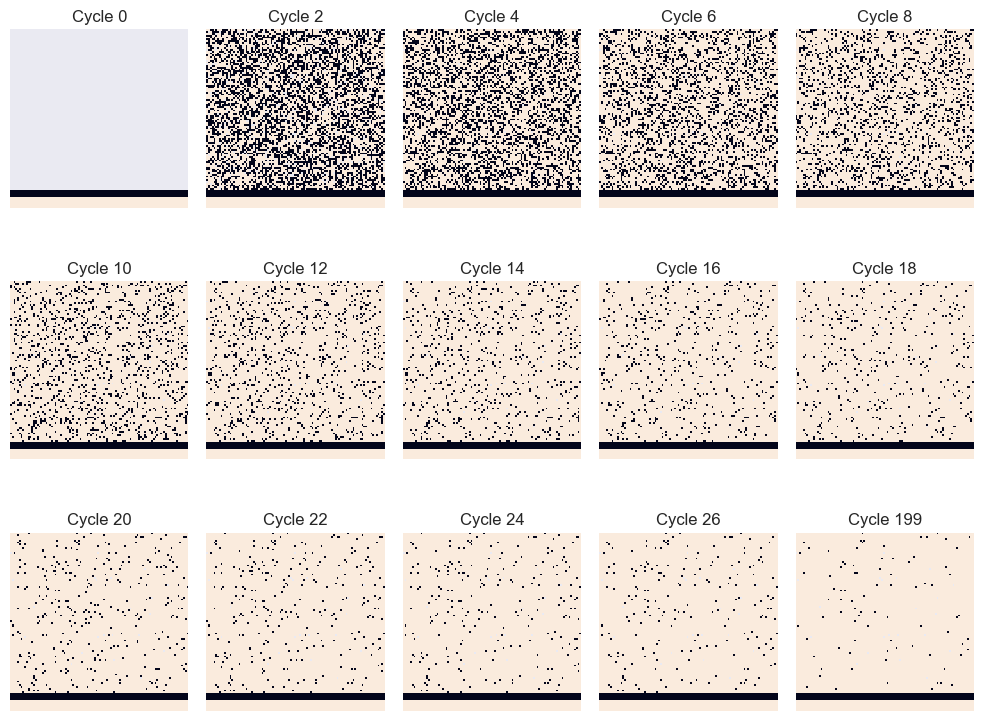

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))

plot_idx = 0
for idx in [*range(0, 28, 2), len(df.columns)-1]:
    axis = ax[plot_idx // 5, plot_idx % 5]
    data = df[idx].to_numpy().reshape((int(np.sqrt(df.shape[0])), int(np.sqrt(df.shape[0]))))
    sns.heatmap(data, ax=axis, square=True, cbar=False, xticklabels=False, yticklabels=False)
    axis.set_title(f"Cycle {idx}")
    plot_idx += 1

fig.tight_layout()

# State variation and convergence of non-sample nodes with time

View of the full time state iteration for non-sample nodes, we see that for a majority of nodes converge to the honest value within a few tens of time steps. A few nodes however, do not converge, this is due to a design choice made in the algorithm for performance reasons and is discussed further under improvements (point 3). The convergence of the network is only marginally affected by this choice.

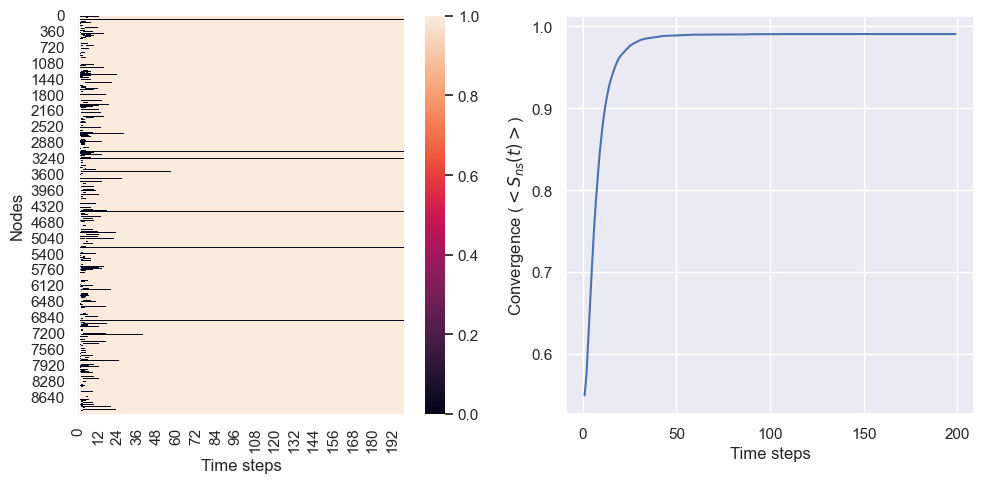

In [7]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(df[:num_non_sample_nodes - 1], ax=ax)
ax.set_xlabel("Time steps")
ax.set_ylabel("Nodes")

sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax1)
ax1.set_xlabel("Time steps")
ax1.set_ylabel(r"Convergence ($<S_{ns}(t)>$)")
fig.tight_layout()

# Number of adversarial nodes 

In [8]:
def s_adv(p, k):
    return (1 - p) * p**k

Text(0, 0.5, '$Pr(s_{adv} = k)$')

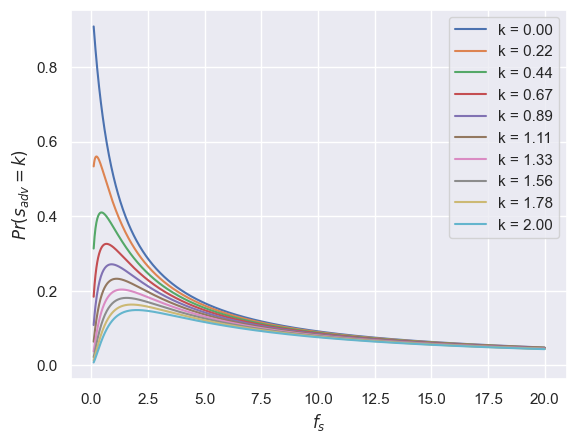

In [9]:
fig, ax = plt.subplots()

fs = np.linspace(0.1, 20, 1000)
ps = fs / (fs + 1)
ks = np.linspace(0, 2, 10)

for k in ks:
    s_sdvs = [s_adv(p, k) for p in ps]
    sns.lineplot(x=fs, y=s_sdvs, ax=ax, label=f"k = {k:.2f}")

ax.set_xlabel(r"$f_s$")
ax.set_ylabel(r"$Pr(s_{adv} = k)$")

# Variation with s

Here we look at the convergence behavior with varying fraction of sample nodes.

To improve speed we reduce the total number of nodes to 1000. The fraction of adversarial sample nodes is pinned to 0.3 * number of sample nodes. Again, we are looking at the worst case scenario with all adversarial nodes emitting the same value. We see that increasing the sample fraction affects the at-equilibrium value of the network, causing it to equilibrate below the ideal value for larger fractions of sample nodes. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it]


Text(0.5, 1.0, 'Variation with fraction of sample nodes $f_s = s/n$, ($s_{adv}/s = 0.3$)')

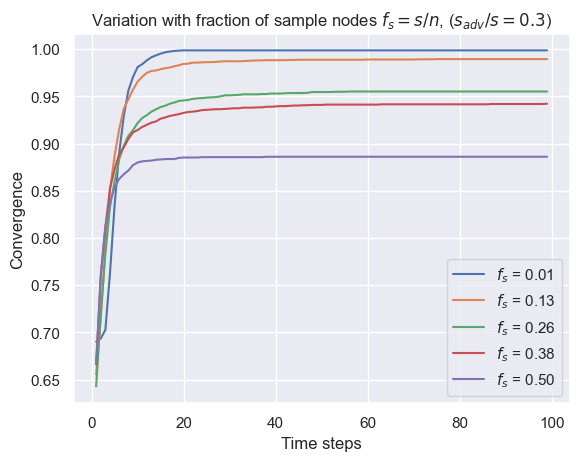

In [10]:
total_nodes = 5000

fig, ax = plt.subplots()

sample_fractions = np.linspace(0.01, 0.5, 5)

for sample_fraction in tqdm(sample_fractions):
    frac_adversarial_sample = 0.3
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = 5

    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=rf"$f_s$ = {sample_fraction:.2f}")
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of sample nodes $f_s = s/n$, ($s_{adv}/s = 0.3$)")

# Variation with f

Here we look at the convergence behavior with varying fraction of adversarial nodes.

The fraction of sample nodes is pinned to 0.01. Here we clearly resolve two sets of behaviors, describing a clear threshold of adversarial nodes (>50%) at which the network will converge to the adversarial value.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


Text(0.5, 1.0, 'Variation with fraction of adversarial sample $f_{adv} = s_{adv} / s$, ($s/n = 0.01$)')

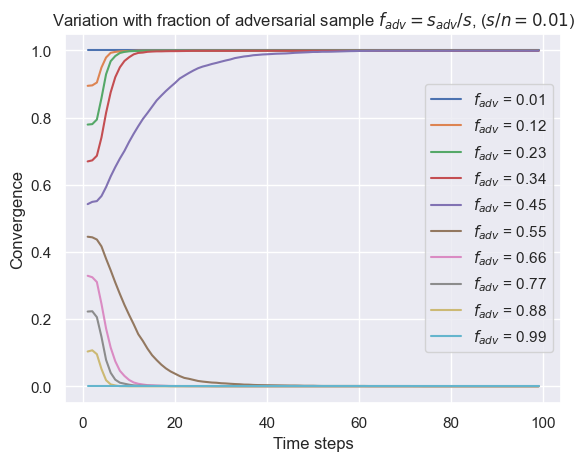

In [11]:
total_nodes = 5000

fig, ax = plt.subplots()

adversarial_sample_fractions = np.linspace(0.01, 0.99, 10)
sample_fraction = 0.01

for frac_adversarial_sample in tqdm(adversarial_sample_fractions):
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = 5

    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=r"$f_{adv}$ = " + f"{frac_adversarial_sample:.2f}")

ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of adversarial sample $f_{adv} = s_{adv} / s$, ($s/n = 0.01$)")

# Variation with K

Here we look at the convergence behavior with varying fraction of connected nodes.

The fraction of sample nodes is pinned to 0.01, and adversarial nodes is pinned to 0.15. This impacts the pre-equilibrium behavior of the network, where more connections between nodes causes the network to converge faster, as expected. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


Text(0.5, 1.0, 'Variation with fraction of connected nodes $f_{K} = K / n$, ($s/n = 0.01, f_{adv} = 0.3$)')

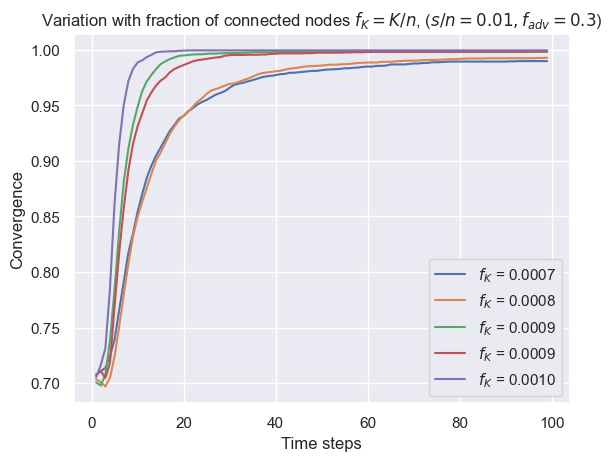

In [12]:
total_nodes = 5000

fig, ax = plt.subplots()

num_connected_fractions = np.linspace(0.0007, 0.001, 5)
sample_fraction = 0.01

for num_connected_frac in tqdm(num_connected_fractions):
    frac_adversarial_sample = 0.3
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = int(num_connected_frac * total_nodes)
    
    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=r"$f_K$ = " + f"{num_connected_frac:.4f}")
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of connected nodes $f_{K} = K / n$, ($s/n = 0.01, f_{adv} = 0.3$)")

# Distribution of storage size on non-sample nodes

Limiting the storage $C$ limits the node's ability to maintain "receipts" of all messages, but since we use a max(counter) algorithm, it does not affect the final result. We do note that a small amount of nodes do appear to show no messages at all. It is not clear if this is a bug (more likely), or this was caused purely by randomness (unlikely).

<Axes: >

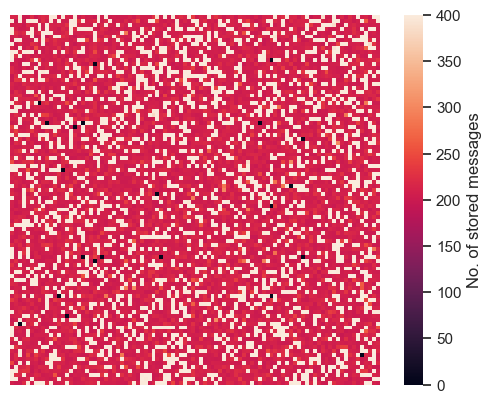

In [13]:
fig, ax = plt.subplots()

num_messages = np.zeros(len(state_transition_func.non_sample_nodes))

for idx, node in enumerate(state_transition_func.non_sample_nodes):
    num_messages[idx] = len(node.stored_messages)

# Since no. of non sample nodes, may not be a perfect square, round down to generate square heatmap
pixels = int(np.sqrt(len(num_messages)))
sns.heatmap(num_messages[:pixels**2].reshape((pixels, pixels)), cbar_kws={"label": "No. of stored messages"}, 
            xticklabels=False, yticklabels=False, square=True)

# Variation of ε 

We observe a large scale convergence of the network to the honest value, with approximately 99.8% of the nodes having at least one honest value in their storage. The deviated in the remaining 0.2% of nodes is likely from the feature visible in the previous example, where some nodes show 0 messages (and thus, of course, cannot have an honest value in their storage).

<Axes: >

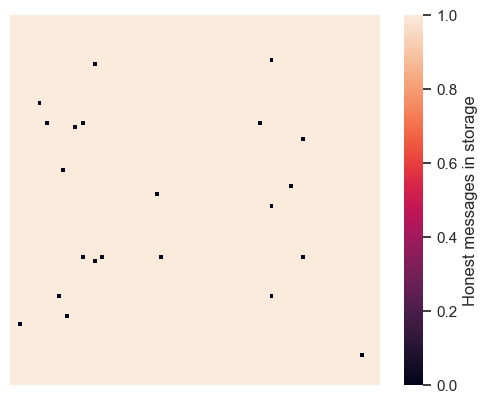

In [14]:
honest_msg_in_storage = np.zeros(len(state_transition_func.non_sample_nodes))

for idx, node in enumerate(state_transition_func.non_sample_nodes):
    if any(node.stored_messages) == Message.HONEST.value:
        honest_msg_in_storage[idx] = 1

pixels = int(np.sqrt(len(honest_msg_in_storage)))
sns.heatmap(honest_msg_in_storage[:pixels**2].reshape((pixels, pixels)), cbar_kws={"label": "Honest messages in storage"}, 
            xticklabels=False, yticklabels=False, square=True)

# Improvements:
1. The nodes can cryptographically sign messages they emit with their node_id. MWE:

```python
import hashlib

class NonSampleNode:
    def sign_message(msg: str, node_id: int) -> str:
        return hashlib.sha256(f"{msg}-{node_id}").hexdigest()
    
    def broadcast(self) -> dict:
        msg = Message.HONEST
        data = {
            "node_id": self.node_id,
            "msg": msg
            "signature": self.sign_message(msg, self.node_id)
        }
        return data
```

2. The storage of the nodes can be capped (note this doesn't affect the max(counter) algorithm). This can be achieved by using a double ended queue (deque), where we push into storage at the right, and pop out of storage on the left. MWE:

```python
from collections import deque

class NonSampleNode:
    def __init__(self, storage_cap: int):
        self.stored_messages: deque[Message] = deque(maxlen=storage_cap)

    def update(self, messages: list[Message]):
        # Will append till maxlen, then will popleft and pushright
        self.stored_messages.append(messages)
```

3. The node randomization algorithm only runs once at the beginning, this was a conscious design choice to improve the speed of iterations. However, support for each time step resampling is present in the algorithm and can be enabled by calling `iterate_state()` with `resample_peers_each_step` set to True (False by default). 

4. As it stands, adversarial nodes are only present in the sample. This could be extended into the whole set of nodes, potentially by either randomizing the broadcast message of the non-sample nodes (note that max(counter) should still be resilient against this, assuming a limited fraction of adversarial non-sample nodes) or setting them to emit the same value as the adversarial sample nodes (maximum collusion) 

5. The nodes only use a push strategy, which is efficient at or near equilibrium (few updates needed), but inefficient away from equilibrium (more updates needed). Potentially this could be fixed by adopting a push-pull strategy as described in [6].

6. The nodes have no concept of topology, and are randomly connected together. This could be modified by using a mesh grid topology, where only K-nearest neighbors can interact with one another.

7. It would be nice to formalize the adversarial nodes themselves, this is likely beyond the scope of this work. The discussion in section 4 and section 5 of [3] provides useful insights into how this could be formulated.

8. It would be interesting to take a heartbeat approach, where nodes periodically send out an update to "neighboring" nodes as an aliveness check. This avoids wasting computing resources on sending messages to nodes which may be offline etc. A membership protocol (SWIM) implementation of this is given in [7].

9. Currently, the node generator logic is slow as it iterates through all the nodes and generates a peer list i.e. O($n^2$) in time. Running this at every iteration is expensive (although potentially more robust as it can include a node liveness check), and has been avoided (with some drawbacks as mentioned earlier). Reusing the peer list for a particular node reduces the time complexity to $O(n)$ as we only need to resample the nodes. This would replace the second yield operation with a dictionary lookup, which should share a similar in time complexity i.e. $O(1)$ to $O(n)$ depending on the specific case. The memory complexity of yield is better as it would be sub-$O(n)$ vs the dictionary which will always be $O(n)$.

# Additional notes for testing

- Inter-node communication can be tested by first querying the peers to which a node is connected `Node.peers`, and checking the state of `message_queue`
- The storage of any non-sample node at any point of time can be observed by querying `NonSampleNode.stored_messages`, the counts can be similarly queried using `NonSampleNode.counter`
- To check whether a `SampleNode` is adversarial or not, query `SampleNode.msg` the result of which will be an element of the `Message` Enum
- The helper function `generate_nodes_and_run_stf` can be used as a quick way to set up nodes and run the state transition function

# References

- [1] Pittel, B. (1987) On a Daley-Kendal Model of Rumours. Journal of Applied Probability, 27, 14-27.
- [2] Alan Demers, Dan Greene, Carl Houser, Wes Irish, John Larson, Scott Shenker, Howard Sturgis, Dan Swinehart, and Doug Terry. 1988. Epidemic algorithms for replicated database maintenance. SIGOPS Oper. Syst. Rev. 22, 1 (Jan., 1988), 8–32. https://doi.org/10.1145/43921.43922
- [2] Sandro Coretti, Aggelos Kiayias, Cristopher Moore, and Alexander Russell. 2022. The Generals' Scuttlebutt: Byzantine-Resilient Gossip Protocols. In Proceedings of the 2022 ACM SIGSAC Conference on Computer and Communications Security (CCS '22). Association for Computing Machinery, New York, NY, USA, 595–608. https://doi.org/10.1145/3548606.3560638
- [3] van den Berg, L., Gattinger, M. (2020). Dealing with Unreliable Agents in Dynamic Gossip. In: Martins, M.A., Sedlár, I. (eds) Dynamic Logic. New Trends and Applications. DaLi 2020. Lecture Notes in Computer Science(), vol 12569. Springer, Cham. https://doi.org/10.1007/978-3-030-65840-3_4
- [4] N. Loizou and P. Richtárik, "Revisiting Randomized Gossip Algorithms: General Framework, Convergence Rates and Novel Block and Accelerated Protocols," in IEEE Transactions on Information Theory, vol. 67, no. 12, pp. 8300-8324, Dec. 2021, doi: 10.1109/TIT.2021.3113285.
- [5] Gossip-based Protocols for Large-scale Distributed Systems. Márk Jelasity, 2013
- [6] Adaptive Push-Then-Pull Gossip Algorithm for Scale-free Networks. Ruchir Gupta, Abhijeet C. Maali, Yatindra Nath Singh, Senior Member IEEE. https://arxiv.org/pdf/1310.5985.pdf
- [7] SWIM: Scalable Weakly-consistent Infection-style Process Group Membership Protocol. Abhinandan Das, Indranil Gupta, Ashish Motivala